In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Labor Productivity Process
In the Aiyagari (1994) model, household (log-) labor productivity, $\varepsilon_t$, follows an AR(1) process with persistence parameter $\rho$. To simplify the model solution, we approximate the AR(1) process using a discrete Markov chain. This approximation is performed using "Tauchen's method," a standard approach for discretizing continuous state spaces. The function `approx_markov` is used to generate the corresponding Markov chain.

In [2]:
def approx_markov(rho, sigma_u, m=3, n=7):
    """
    Computes the Markov matrix associated with a discretized version of
    the linear Gaussian AR(1) process

        y_{t+1} = rho * y_t + u_{t+1}

    according to Tauchen's method.  Here {u_t} is an iid Gaussian
    process with zero mean.

    Parameters
    ----------
    rho : scalar(float)
        The autocorrelation coefficient
    sigma_u : scalar(float)
        The standard deviation of the random process
    m : scalar(int), optional(default=3)
        The number of standard deviations to approximate out to
    n : scalar(int), optional(default=7)
        The number of states to use in the approximation

    Returns
    -------

    x : array_like(float, ndim=1)
        The state space of the discretized process
    P : array_like(float, ndim=2)
        The Markov transition matrix where P[i, j] is the probability
        of transitioning from x[i] to x[j]

    """
    F = scipy.stats.norm(loc=0, scale=sigma_u).cdf

    # standard deviation of y_t
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # top of discrete state space
    x_max = m * std_y

    # bottom of discrete state space
    x_min = - x_max

    # discretized state space
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    for i in range(n):
        P[i, 0] = F(x[0]-rho * x[i] + half_step)
        P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
        for j in range(1, n-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)

    return x, P

In the next step we generate the markov chain approximation of an AR(1) process with `neta=7` realizations, persistence $\rho=0.965$, and standard deviation $\sigma=0.25$. The realizations of the shock are given by `y` and the transition matrix is given by `yprob`.

In [3]:
neta = 7 # number of realizations
rho_e = 0.965 # persistence
sig_e = 0.25 # standard deviation

# discretize the AR-process into a markov chain
y, yprob = approx_markov(rho_e, sig_e, 3, neta)

# normalization
y = np.exp(y)

Next we compute the stationary distribution of the process, and the mean labor supply under the AR(1) process.

In [4]:
# find the stationary distribution of the markov chain
S, U = scipy.linalg.eig(yprob.T)
pistar = np.array(U[:, np.where(np.abs(S - 1.) < 1e-8)[0][0]].flat)
pistar = pistar / np.sum(pistar)

# aggregate labor supply
var_x = sig_e**2.0 / (1.0 - rho_e**2.0)
labor = np.exp(var_x / 2.0)

### Exercise

In [5]:
# ECONOMIC PARAMETERS

# risk aversion
gam = 2.0
# rate of depreciation
delta = 0.08
# discount factor
betta = 0.92
# capital share of income
alpha = 0.33

In [6]:
# GRID PARAMETERS

# number of points
na = 101
# lower bound
amin = 0.0
# upper bound
amax = 500.0
# construct grid for the household problem
agrid = np.linspace(amin, amax, na)

In [7]:
# EXOGENOUS INTEREST RATE

# set an interest rate
irate = 0.04

# calculate agg. capital and wage rate implied by the interest rate
cap = ((labor**(alpha-1.0)*(delta + irate))/alpha)**(1.0/(alpha-1.0))
wage = (1.0-alpha)*cap**alpha*labor**(-alpha)

In [8]:
# INITIAL GUESS

# pre-allocation
c_guess = np.zeros((na, neta))
c_new = np.zeros((na, neta))
a_endo = np.zeros((na, neta))
a_star = np.zeros(neta)
con = np.zeros((na, neta))
ap = np.zeros((na, neta))

# set a guess for the consumption policy
for iy in range(neta):
    c_guess[:, iy] = irate * agrid + wage * y[iy]

In [9]:
# MAIN LOOP

maxiter = 10000
epsilon = 1e-7
for iter0 in range(maxiter):

    # Step 1: Determine the grid points where the borrowing constraint is just binding
    for ia in range(na):
        for iy in range(neta):
            # Calculate the RHS of equation (5)
            rhs = betta * (1.0 + irate) * c_guess[ia, :] ** (-gam) @ np.transpose(yprob[iy, :])
            # Calculate the implied consumption (as a function of a')
            c_new[ia, iy] = rhs ** (-1.0 / gam)
            # Use the budget constraint to calculate the implied savings today (as a function of a')
            a_endo[ia, iy] = (agrid[ia] + c_new[ia, iy] - wage * y[iy]) / (1.0 + irate)

            # Calculate savings today that correspond to a choice of a'=0
            if (ia == 0):
                a_star[iy] = a_endo[0, iy]

    # Step 2: Retrieve an updated guess for the consumption policy
    for ia in range(na):
        for iy in range(neta):
            # In this case, use the budget constraint to determine consumption
            if (agrid[ia] < a_star[iy]):
                con[ia, iy] = (1.0 + irate) * agrid[ia] + wage * y[iy]
                ap[ia, iy] = 0.0
            else:
                # In this case, use linear interpolation to determine consumption
                con[ia, iy] = np.interp(agrid[ia], a_endo[:, iy], c_new[:, iy])
                ap[ia, iy] = (1.0 + irate) * agrid[ia] + wage * y[iy] - con[ia, iy]

    metricEGM = np.amax(np.abs(con - c_guess))

    tolEGM = epsilon * (1.0 + np.amax(np.amax(np.abs(c_guess))))

    # print(iter0, metricEGM)

    if (metricEGM < tolEGM):
        break

    # The new guess for the consumption policy
    c_guess = np.copy(con)


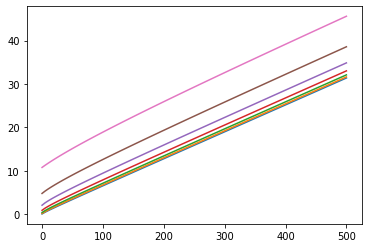

In [10]:
# PLOT RESULTS

plt.figure()
for i in range(neta):
    plt.plot(agrid, con[:, i])
plt.show()